In [ ]:
# This notebook compers stansart cluster 

In [1]:
from KMDAlgo import KMDLinkage
import numpy as np
import matplotlib.pyplot as plt
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice
import cluster_scoring
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
import warnings
%matplotlib inline

In [5]:
### generate datasets ###
np.random.seed(1)
n_samples = 1000

# nested circle data
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.3,
                                      noise=0.14)
# moons dataset
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.24)

# Anisotropicly distributed data
random_state = 185
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(n_samples=n_samples, cluster_std=[2, 2, 2],random_state=random_state)

In [6]:
# Set up cluster parameters
# note that recomended k_scan_range is 1 to 100, the range was reduced to save time 
default_base = {
                'n_neighbors': 10,
                'n_clusters': 3,
                'min_samples': 20,
                'min_cluster_size': 0.1,
                'k':'compute',
                'k_scan_range' :(10,20,5)
                }

datasets = [
    (noisy_circles, {'eps': 0.15,'n_clusters': 2, 'k':'compute', 'k_scan_range' : (10,20,5)}),
    (noisy_moons, {'eps': 0.15,'n_clusters': 2, 'k':'compute', 'k_scan_range' : (40,50,5)}),
    (varied, {'eps': .18, 'n_neighbors': 2,'min_samples': 5, 'min_cluster_size': .2, 'k':'compute', 'k_scan_range' :(10,20,5)}),
    (aniso, {'eps': .15, 'n_neighbors': 2,'min_samples': 20,  'min_cluster_size': .2, 'k':'compute', 'k_scan_range' : (10,20,5)}),
]

In [7]:
#Set up figure 
f =plt.figure(1,figsize=(9 * 2 + 3, 12.5))
plot_num = 1

<Figure size 1512x900 with 0 Axes>

k=10
sil_score
0.734141666588036
k=15
sil_score
0.7363428924561418
Predicted k is : 15
k=10
sil_score
0.734141666588036
k=15
sil_score
0.7363428924561418
Predicted k is : 15
k=40
sil_score
0.873133855072338
k=45
sil_score
0.765352131675975
Predicted k is : 40
k=40
sil_score
0.873133855072338
k=45
sil_score
0.765352131675975
Predicted k is : 40
k=10
sil_score
0.14946460599754005
k=15
sil_score
0.1762847867870498
Predicted k is : 15
k=10
sil_score
0.14946460599754005
k=15
sil_score
0.1762847867870498
Predicted k is : 15


C:\Users\sivan\Anaconda2\envs\py36\lib\site-packages\sklearn\cluster\_agglomerative.py:502: UserWarning: the number of connected components of the connectivity matrix is 42 > 1. Completing it to avoid stopping the tree early.
  affinity=affinity)


k=10
sil_score
0.4325320187607942
k=15
sil_score
0.44646430572262524
Predicted k is : 15
k=10
sil_score
0.4325320187607942
k=15
sil_score
0.44646430572262524
Predicted k is : 15


C:\Users\sivan\Anaconda2\envs\py36\lib\site-packages\sklearn\cluster\_agglomerative.py:502: UserWarning: the number of connected components of the connectivity matrix is 51 > 1. Completing it to avoid stopping the tree early.
  affinity=affinity)


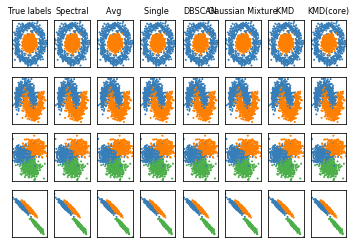

In [8]:
# Iterate on all datasets 
for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)
    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph( X, n_neighbors=params['n_neighbors'], include_self=False)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # Create cluster objects
    HAC_single = cluster.AgglomerativeClustering(n_clusters=params['n_clusters'], linkage='single',connectivity=connectivity)
    spectral = cluster.SpectralClustering(n_clusters=params['n_clusters'], eigen_solver='arpack',affinity="nearest_neighbors")
    dbscan = cluster.DBSCAN(eps=params['eps'])
    average_linkage = cluster.AgglomerativeClustering(linkage="average", n_clusters=params['n_clusters'])
    gmm = mixture.GaussianMixture( n_components=params['n_clusters'], covariance_type='full')
    kmd = KMDLinkage(X, k=params['k'], n_clusters = params['n_clusters'], min_cluster_size = 50, affinity ='compute', certainty = 0.5,
                             k_scan_range = params['k_scan_range'])
    kmd_core = KMDLinkage(X, k=params['k'], n_clusters = params['n_clusters'], min_cluster_size = 50, affinity ='compute', certainty = 1,
                                  k_scan_range = params['k_scan_range'])
    
    clustering_algorithms = (
        ('True labels',0),
        ('Spectral', spectral),
        ('Avg ', average_linkage),
        ('Single ', HAC_single),
        ('DBSCAN', dbscan),
        ('Gaussian Mixture', gmm),
        ('KMD ' ,kmd),
        ('KMD(core)', kmd_core)
    )
    
        # cluster each dataset 
    for name, algorithm in clustering_algorithms:
        if algorithm != 0:
                algorithm.fit(X)
        elif name == 'True labels':
            y_pred= y
        elif hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            y_pred = algorithm.predict(X)

        core_idx = y_pred != -1
        y_pred_eval = y_pred[core_idx]
        y_eval = y[core_idx]

        plt.subplot(len(datasets), len(clustering_algorithms) , plot_num)

        if i_dataset == 0:
            plt.title(name, size=8)
            
        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a','#f781bf', '#a65628', '#984ea3','#999999', '#e41a1c', '#dede00']),int(max(y_pred) + 1))))
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=1, color=colors[y_pred])
        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plot_num += 1
        